<a href="https://colab.research.google.com/github/wksmirnowa/deeplearning_exam/blob/master/Smirnova_DL_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER

## Импорты

In [115]:
import torch
import codecs
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

## Данные

Загрузим данные

In [116]:
def load_data(path):

  sentences = []
  sentence = []
  for line in codecs.open(path, 'r', 'utf8'):
    line = line.rstrip()
    if not line:
      if len(sentence) > 0:
        if 'DOCSTART' not in sentence[0][0]:
          sentences.append(sentence)
        sentence = []
    else:
      word = line.split()
      assert len(word) >= 2
      sentence.append(word)
  if len(sentence) > 0:
    if 'DOCSTART' not in sentence[0][0]:
      sentences.append(sentence)
  return sentences

In [117]:
train_data = load_data('/content/drive/MyDrive/dl_exam/conllpp_train.txt')
test_data = load_data('/content/drive/MyDrive/dl_exam/conllpp_test.txt')

Посмотрим на даные

In [ ]:
train_data[0]

[['EU', 'NNP', 'B-NP', 'B-ORG'],
 ['rejects', 'VBZ', 'B-VP', 'O'],
 ['German', 'JJ', 'B-NP', 'B-MISC'],
 ['call', 'NN', 'I-NP', 'O'],
 ['to', 'TO', 'B-VP', 'O'],
 ['boycott', 'VB', 'I-VP', 'O'],
 ['British', 'JJ', 'B-NP', 'B-MISC'],
 ['lamb', 'NN', 'I-NP', 'O'],
 ['.', '.', 'O', 'O']]

In [ ]:
test_data[0]

[['SOCCER', 'NN', 'I-NP', 'O'],
 ['-', ':', 'O', 'O'],
 ['JAPAN', 'NNP', 'I-NP', 'B-LOC'],
 ['GET', 'VB', 'I-VP', 'O'],
 ['LUCKY', 'NNP', 'I-NP', 'O'],
 ['WIN', 'NNP', 'I-NP', 'O'],
 [',', ',', 'O', 'O'],
 ['CHINA', 'NNP', 'I-NP', 'B-LOC'],
 ['IN', 'IN', 'I-PP', 'O'],
 ['SURPRISE', 'DT', 'I-NP', 'O'],
 ['DEFEAT', 'NN', 'I-NP', 'O'],
 ['.', '.', 'O', 'O']]

In [ ]:
len(train_data), len(test_data)

(14041, 3453)

Подготовим данные для работы с ними

In [118]:
def get_sentences_and_tags(data: list):

  words_sequences = []
  tags_sequences = []
  for tokens in data:
    words = [el[0].lower() for el in tokens]
    tags = [el[3] for el in tokens]
    words_sequences.append(words)
    tags_sequences.append(tags)
  return words_sequences, tags_sequences

In [119]:
train_sentences, train_tags = get_sentences_and_tags(train_data)
test_sentences, test_tags = get_sentences_and_tags(test_data)

In [ ]:
train_sentences[:3]

[['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'],
 ['peter', 'blackburn'],
 ['brussels', '1996-08-22']]

In [ ]:
test_sentences[:3]

[['soccer',
  '-',
  'japan',
  'get',
  'lucky',
  'win',
  ',',
  'china',
  'in',
  'surprise',
  'defeat',
  '.'],
 ['nadim', 'ladki'],
 ['al-ain', ',', 'united', 'arab', 'emirates', '1996-12-06']]

In [ ]:
train_tags[:3]

[['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'],
 ['B-PER', 'I-PER'],
 ['B-LOC', 'O']]

In [ ]:
test_tags[:3]

[['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O'],
 ['B-PER', 'I-PER'],
 ['B-LOC', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O']]

In [ ]:
len(train_sentences), len(train_tags), len(test_sentences), len(test_tags)

(14041, 14041, 3453, 3453)

Чтобы подобрать длину, до которой будем обрезать и паддить последовательности токенов, изучим, какие длины последовательностей вообще есть в данных.

In [ ]:
np.mean([len(x) for x in train_sentences])

14.501887329962253

In [ ]:
np.max([len(x) for x in train_sentences])

113

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


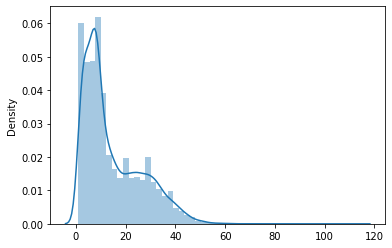

In [ ]:
sns.distplot([len(x) for x in train_sentences])

Подготовим словарь тегов

In [122]:
def make_tags_vocab(train_tags=train_tags, test_tags=test_tags, use_bos_eos=False):
  united_tags = train_tags + test_tags
  all_tags = []
  for line in tqdm(united_tags):
    for el in line:
      all_tags.append(el)
  set_tags = set(all_tags) - {'O'}
  if use_bos_eos:
    tags_vocab = OrderedDict({'<PAD>': 0, '<BOS>': 1, '<EOS>':2, 'O': 3})
  else:
    tags_vocab = OrderedDict({'<PAD>': 0, 'O': 1})
  for word in tqdm(set_tags):
    tags_vocab[word] = len(tags_vocab)
  return tags_vocab

In [123]:
tags_vocab = make_tags_vocab()

100%|██████████| 8/8 [00:00<00:00, 39016.78it/s]


In [124]:
tags_vocab

OrderedDict([('<PAD>', 0),
             ('O', 1),
             ('I-ORG', 2),
             ('I-LOC', 3),
             ('I-MISC', 4),
             ('B-ORG', 5),
             ('B-PER', 6),
             ('B-LOC', 7),
             ('I-PER', 8),
             ('B-MISC', 9)])

На основе частотности тегов подготовим их веса (к сожалению, эти веса не дают такого же результата, как искусственно заданные значения, поэтому в дальнейшем я их не использую)

In [125]:
all_tags = []
for line in train_tags+test_tags:
  for el in line:
    all_tags.append(el)

In [127]:
count_weights = OrderedDict()
for k in tags_vocab.keys():
  for tag in tqdm(all_tags):
    if tag == k:
      if k not in count_weights:
        count_weights[k] = 0
      else:
        count_weights[k] += 1


100%|██████████| 250056/250056 [00:00<00:00, 3097190.41it/s]


In [128]:
count_weights

OrderedDict([('O', 207754),
             ('I-ORG', 4585),
             ('I-LOC', 1415),
             ('I-MISC', 1408),
             ('B-ORG', 8035),
             ('B-PER', 8217),
             ('B-LOC', 8785),
             ('I-PER', 5688),
             ('B-MISC', 4160)])

In [129]:
ws = count_weights.values()
normedws = [1 - (x / sum(ws)) for x in ws]
normedws = [0.0] + normedws
normedws

[0.0,
 0.16914020164209131,
 0.9816634472719129,
 0.9943410638799905,
 0.99436905861698,
 0.9678660411842573,
 0.9671381780225318,
 0.9648666050782453,
 0.9772522765720044,
 0.9833631277319864]

## Векторизация

В данной работе я пробую fasttext.

In [130]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2020-12-21 18:30:06--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.1’

wiki-news-300d-1M.v 100%[===================>] 650.22M  26.8MB/s    in 25s     

2020-12-21 18:30:32 (25.5 MB/s) - ‘wiki-news-300d-1M.vec.zip.1’ saved [681808098/681808098]



In [132]:
def load_embeddings(zip_path, filename, pad_token='<PAD>', max_words=100000, verbose=True):
    
    vocab = dict()
    embeddings = list()

    with zipfile.ZipFile(zip_path) as zipped_file:
        with zipped_file.open(filename) as file_object:

            vocab_size, embedding_dim = file_object.readline().decode('utf-8').strip().split()

            vocab_size = int(vocab_size)
            embedding_dim = int(embedding_dim)
            
            max_words = vocab_size if max_words <= 0 else max_words
            
            vocab[pad_token] = len(vocab)
            embeddings.append(np.zeros(embedding_dim))

            progress_bar = tqdm(total=max_words, disable=not verbose)

            for line in file_object:
                parts = line.decode('utf-8').strip().split()

                token = ' '.join(parts[:-embedding_dim]).lower()
                
                if token in vocab:
                    continue
                
                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                vocab[token] = len(vocab)
                embeddings.append(word_vector)

                progress_bar.update()
                
                if len(vocab) == max_words:
                    break

            progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings

In [134]:
embedding_vocab, embeddings = load_embeddings('wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec')

100%|█████████▉| 99999/100000 [00:10<00:00, 9914.36it/s]


In [135]:
embeddings = torch.tensor(embeddings).float()

## Датасет

Напишем обработчик данных (свой класс, который наследует торчовый класс Dataset)

In [136]:
class NERDataset(Dataset):
    
    def __init__(self, sentences, tags, text_vocab, tags_vocab, pad_index=0, max_len=40):
        super().__init__()
        
        self.sentences = sentences
        self.tags = tags
        self.text_vocab = text_vocab
        self.tags_vocab = tags_vocab
        self.pad_index = pad_index
        self.max_len = max_len
        
    def __len__(self):

        return len(self.sentences)
    
    def get_text_indeces(self, sentence):

        return [self.text_vocab[token] for token in sentence if token in self.text_vocab]

    def get_tag_indeces(self, tags):

        return [self.tags_vocab[tag] for tag in tags]
    
    def padding(self, sequence):

        padds = [self.pad_index] * (self.max_len - len(sequence))
        sequence = sequence + padds
        return sequence
    
    def __getitem__(self, index):
       
        text = self.sentences[index][:self.max_len]      
        tag = self.tags[index][:self.max_len]
        indeces_of_text = self.get_text_indeces(text)
        indeces_of_tag = self.get_tag_indeces(tag)
        padded_text = self.padding(indeces_of_text)
        padded_tag = self.padding(indeces_of_tag)
        converted_text = torch.tensor(padded_text)
        converted_tag = torch.tensor(padded_tag)

        return converted_text, converted_tag

In [137]:
train_dataset = NERDataset(sentences=train_sentences, tags=train_tags, text_vocab=embedding_vocab, tags_vocab=tags_vocab)
valid_dataset = NERDataset(sentences=test_sentences, tags=test_tags, text_vocab=embedding_vocab, tags_vocab=tags_vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

Проверим, что всё работает, как надо

In [138]:
for x, y in train_loader:
    break

In [141]:
x

tensor([[   35,  1406,     4,  ...,     0,     0,     0],
        [27365,    50,    22,  ...,   376,     0,     0],
        [ 7279,    27,  1431,  ...,     0,     0,     0],
        ...,
        [ 6776,   214,  6674,  ...,     0,     0,     0],
        [64277, 15901,    13,  ...,     0,     0,     0],
        [   44,   138, 26981,  ...,     0,     0,     0]])

In [142]:
y

tensor([[1, 7, 1,  ..., 0, 0, 0],
        [6, 1, 6,  ..., 1, 9, 1],
        [5, 1, 7,  ..., 0, 0, 0],
        ...,
        [5, 1, 5,  ..., 0, 0, 0],
        [1, 6, 8,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [143]:
x.shape, y.shape

(torch.Size([64, 40]), torch.Size([64, 40]))

In [145]:
tags_invert_vocab = {v:k for k,v in tags_vocab.items()}
embedding_invert_vocab = {v:k for k,v in embedding_vocab.items()}

In [148]:
text_x = [embedding_invert_vocab[el] for el in x.numpy()[2]]
text_x

['milwaukee',
 'at',
 'chicago',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

In [149]:
text_y = [tags_invert_vocab[el] for el in y.numpy()[2]]
text_y

['B-ORG',
 'O',
 'B-LOC',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

## Модель

In [150]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [151]:
class SpatialDropout(torch.nn.Dropout2d):
    
    def __init__(self, p=0.3):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        x = x.unsqueeze(2)
        x = x.permute(0, 3, 2, 1)
        x = super(SpatialDropout, self).forward(x)
        x = x.permute(0, 3, 2, 1)
        x = x.squeeze(2)
        return x

In [152]:
spatial_dropout = SpatialDropout()

In [174]:
class NERLSTM(torch.nn.Module):
    
    def __init__(self, embeddings, tags_vocab_size, hidden_dim, num_lstm_layers, spatial_dropout):
        
        super().__init__()
        

        self.embedding_layer = nn.Embedding.from_pretrained(embeddings, padding_idx=0, freeze=False)
        
        self.spatial_dropout = spatial_dropout

        self.input_size = embeddings.shape[-1]


        self.lstm = torch.nn.LSTM(input_size=self.input_size, 
                                  hidden_size=hidden_dim,
                                  num_layers=num_lstm_layers, 
                                  batch_first=True,
                                  bidirectional=False)
  
        
        self.output_layer = torch.nn.Linear(in_features=hidden_dim,
                                            out_features=tags_vocab_size,
                                            bias=False)

        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        x = self.spatial_dropout(x)
        x, _ = self.lstm(x)
        x = self.output_layer(x)
        
        return x

In [158]:
model = NERLSTM(embeddings=embeddings,
                tags_vocab_size=len(tags_vocab),
                hidden_dim=128,
                num_lstm_layers=4, 
                spatial_dropout=spatial_dropout)
model.to(device)

NERLSTM(
  (embedding_layer): Embedding(100000, 300, padding_idx=0)
  (spatial_dropout): SpatialDropout(p=0.3, inplace=False)
  (lstm): LSTM(300, 128, num_layers=4, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=False)
)

## Обучение, оценивание

In [176]:
def train_model(model, train_loader, optimizer, criterion, n_epoch, weights, clip=3.0):

    train_losses = list()

    model.train()
    
    train_progress_bar = tqdm(total=len(train_loader.dataset), desc=f'Epoch: {n_epoch + 1}, train')
    
    for instance in list(tqdm._instances):
      tqdm._decr_instances(instance)

    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
            
        pred = model(x)
        
        loss = criterion(pred.cpu().view(-1, pred.cpu().size(-1)), y.cpu().view(-1))

        loss = loss * weights[y.cpu().view(-1)]
        loss = loss.mean()
        

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())

        train_progress_bar.set_postfix(train_loss = np.mean(train_losses[-500:]))
        train_progress_bar.update(x.shape[0])

    train_progress_bar.close()

    return train_losses

In [177]:
def validate_model(model, valid_loader, optimizer, criterion, n_epoch, weights):

    valid_losses = []

    model.eval()

    valid_progress_bar = tqdm(total=len(valid_loader.dataset), desc=f'Epoch: {n_epoch + 1}, validation')

    for instance in list(tqdm._instances):
      tqdm._decr_instances(instance)

    for x, y in valid_loader:

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():  
            pred = model(x)
       
        loss = criterion(pred.cpu().view(-1, pred.cpu().size(-1)), y.cpu().view(-1))

        loss = loss * weights[y.cpu().view(-1)]
        loss = loss.mean()

        valid_losses.append(loss.item())

        valid_progress_bar.set_postfix(valid_loss = np.mean(valid_losses[-500:]))
        valid_progress_bar.update(x.shape[0])
    
    valid_progress_bar.close()

    return valid_losses

In [159]:
%%time
model_params = [x[1] for x in list(filter(lambda x: x[0] != 'embedding_layer.weight', model.named_parameters()))]
embedding_params = model.embedding_layer.parameters()
best_val_loss = 10.
losses = list()
val_losses = list()
tr_losses = list()

weights = torch.tensor([0.0,0.3,0.63,0.63,0.63,0.63,0.63,0.63,0.63,0.63])
# weights = torch.tensor(normedws)

criterion = nn.CrossEntropyLoss(weight=weights, reduction='none', ignore_index=0)
optimizer = torch.optim.Adam(params=[{'params': embedding_params, 'lr': 0.0001}, {'params': model_params, 'lr': 0.0001}])
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

for n_epoch in range(30):

  epoch_train_losses = train_model(model, train_loader, optimizer, criterion, n_epoch, weights)
  epoch_valid_losses = validate_model(model, valid_loader, optimizer, criterion, n_epoch, weights)
  
  for l in epoch_train_losses:
    losses.append(l)

  mean_epoch_val_loss = np.mean(epoch_valid_losses)
  mean_epoch_train_loss = np.mean(epoch_train_losses)

  val_losses.append(mean_epoch_val_loss)
  tr_losses.append(mean_epoch_train_loss)

  scheduler.step()

  if mean_epoch_val_loss < best_val_loss:
    best_val_loss = mean_epoch_val_loss
    torch.save(model.state_dict(), f'best_model_state_dict.pth')
    torch.save(optimizer.state_dict(), 'best_optimizer_state_dict.pth')
  else:
    # print(f'Early stopping on epoch {n_epoch+1}')
    torch.save(model.state_dict(), f'last_model_state_dict.pth')
    torch.save(optimizer.state_dict(), 'last_optimizer_state_dict.pth')
    # break

Epoch: 1, validation: 100%|██████████| 3453/3453 [00:00<00:00, 7289.82it/s, valid_loss=0.0782]
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch: 30, validation: 100%|██████████| 3453/3453 [00:00<00:00, 7326.14it/s, valid_loss=0.0379]


CPU times: user 2min 43s, sys: 35.2 s, total: 3min 18s
Wall time: 4min 13s


## Оценка модели

Лучший результат со значениями
```python
weights = torch.tensor([0.0,0.3,0.63,0.63,0.63,0.63,0.63,0.63,0.63,0.63])
num_lstm_layers=4
```

In [165]:
model.load_state_dict(torch.load('best_model_state_dict.pth'))

<All keys matched successfully>

### Графики и значения лоссов

In [180]:
def show_losses_graph(losses, training=True, epoch=True):
  plt.figure(figsize=(7, 7))
  plt.plot(losses)
  plt.grid()
  if training:
    plt.title('Training process')
  else:
    plt.title('Validation process')
  if epoch:
    plt.xlabel('Epochs')
  else:
    plt.xlabel('Iterations')
  plt.ylabel('Loss function')

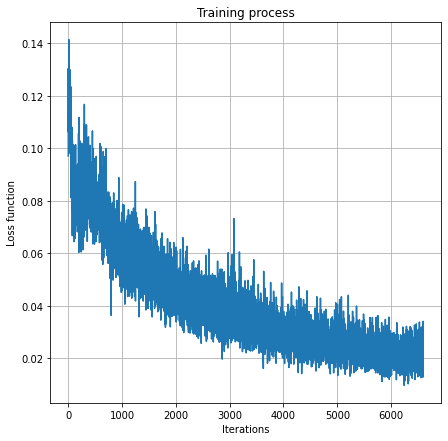

In [160]:
show_losses_graph(losses, epoch=False)

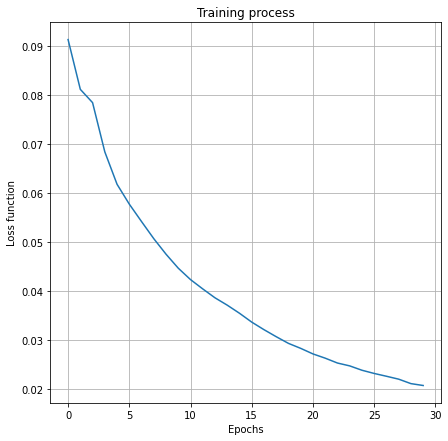

In [161]:
show_losses_graph(tr_losses)

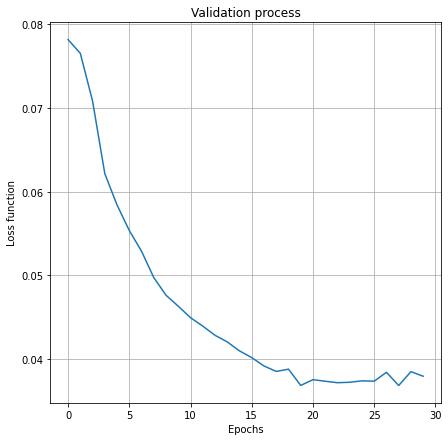

In [162]:
show_losses_graph(val_losses, training=False)

In [163]:
# Лосс на трейне
np.mean(tr_losses)

0.040674534431856244

In [164]:
# Лосс на тесте
np.mean(val_losses)

0.046064005303484055

### Значение f-меры

In [166]:
%%time
model.eval()
y_true = list()
y_pred = list()
for x, y in tqdm(valid_loader):
  x = x.to(device)
  y = y.to(device)
  with torch.no_grad():
    pred = model.forward(x)
    y_pred.append(pred.argmax(dim=-1).detach().cpu().numpy().tolist())
    y_true.append(y.cpu().numpy().tolist())

100%|██████████| 54/54 [00:00<00:00, 172.64it/s]

CPU times: user 308 ms, sys: 9.33 ms, total: 317 ms
Wall time: 323 ms


In [167]:
trues = []
predictions = []
count_tags = 0
tags = []
for batch_true, batch_pred in zip(y_true, y_pred):
  for sentence_true, sentence_pred in zip(batch_true, batch_pred):
    for token_true, token_pred in zip(sentence_true, sentence_pred):
      if token_true != 0:
        if token_pred != tags_vocab['O']:
          count_tags+=1
          tags.append(tags_invert_vocab[token_pred])
        trues.append(token_true)
        predictions.append(token_pred)


In [168]:
count_tags

9654

In [191]:
trues[:20]

[1, 1, 7, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [192]:
predictions[:20]

[1, 1, 7, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [194]:
f1_score(trues, predictions, average='micro')

0.8582259619598562

In [218]:
f1_score(trues, predictions, average='macro')

0.561590145597014

In [193]:
print(classification_report(trues, predictions))

              precision    recall  f1-score   support

           1       0.96      0.91      0.93     37581
           2       0.39      0.53      0.45       860
           3       0.49      0.52      0.50       256
           4       0.34      0.44      0.39       251
           5       0.46      0.58      0.51      1701
           6       0.56      0.61      0.58      1561
           7       0.53      0.69      0.60      1616
           8       0.57      0.61      0.59      1096
           9       0.48      0.51      0.50       714

    accuracy                           0.86     45636
   macro avg       0.53      0.60      0.56     45636
weighted avg       0.87      0.86      0.87     45636



### Пример предсказания

In [199]:
import nltk
nltk.download('punkt')
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer().tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [217]:
example_text = "Harry Potter is a series of seven fantasy novels written by British author Joanne Rowling"
example = tokenizer(example_text.lower())
example_ids = [embedding_vocab[token] for token in example if token in embedding_vocab]
padds = [0] * (40 - len(example_ids))
example_padds = example_ids + padds
example_tensor = torch.tensor(example_padds)
example_tensor = torch.unsqueeze(example_tensor,0)
 
preds = []
with torch.no_grad():
  pred = model.forward(example_tensor.to(device))
  preds.append(pred.argmax(dim=-1).detach().cpu().numpy().tolist())
predicted_tags = [tags_invert_vocab[i] for i in preds[0][0]]
words = [embedding_invert_vocab[token] for token in example_ids if token in embedding_invert_vocab]

for w,t in zip(words, predicted_tags):
  print(w,t)

harry B-PER
potter I-PER
is O
a O
series O
of O
seven O
fantasy O
novels O
written O
by O
british B-MISC
author B-MISC
joanne B-PER
rowling B-PER
